In [96]:
library(tidyverse)
library(umap)

# README

## Best studies:
- PRJEB27928 (GERMANY)
- PRJEB6070  (FRANCE)
- PRJNA429097 (CHINA)
- PRJEB10878 (CHINA)

# plots

In [97]:
pca_plot <- function(df, batch_info, title, path = "", color_column = "condition", shape_column = "lab") {
  pca <- prcomp(t(na.omit(df)))
  # Plot PCA
  pca_df <-
    pca$x %>%
    as.data.frame() %>%
    rownames_to_column("sample") %>% 
    left_join(batch_info,  by = "sample") 
  # add % of explained variance
  var_expl <- pca$sdev^2 / sum(pca$sdev^2)
  names(var_expl) <- paste0("PC", 1:length(var_expl))
  # Add the label for the specific point
  pca_plot <- pca_df %>%
    ggplot(aes(PC1, PC2)) +
    geom_point(aes_string(col=color_column, shape=shape_column), size=2) +
    theme_classic() +
    labs(title = title,
         x = glue::glue("PC1 [{round(var_expl['PC1']*100, 2)}%]"),
         y = glue::glue("PC2 [{round(var_expl['PC2']*100, 2)}%]"))

  if (path == "") {
    return(pca_plot)
  } else {
    ggsave(path, pca_plot)
  }
}


In [98]:
# boxplot
boxplot_pg <- function(protein_matrix, title, path = "") {
  # Reshape data into long format
  long_data <- tidyr::gather(protein_matrix, 
                             key = "sample", value = "Intensity")
  # Log tranformed scale
  boxplot <- ggplot(long_data, aes(x = sample, y = Intensity)) + 
    geom_boxplot() +
    stat_summary(fun = mean, geom = "point", shape = 4, size = 1.5, color = "red") +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1, size = 5)) +
    labs(title = title) 

  if (path == "") {
    return(boxplot)
  } else {
    ggsave(path, boxplot)
  }
}

In [99]:
heatmap_plot <- function(pg_matrix, batch_info, name, plot_name_prefix){
    cor_matrix <- cor(na.omit(pg_matrix), use = "pairwise.complete.obs")
    pheatmap::pheatmap(cor_matrix, 
                        annotation_col = select(batch_info, c(condition, lab)),
                        treeheight_row = 0, treeheight_col = 0, 
                        fontsize_row = 5, fontsize_col = 5,
                        width = 7, height = 7,
                        main = paste0(name, ' heatmap'),
                        filename = plot_name_prefix)
}


In [100]:
plot_three_plots <- function(pg_matrix, batch_info, plot_name_prefix, subname, number){

        batch_info <- batch_info %>%
                mutate(file = case_when(
                lab %in% c('lab_A', 'lab_E') ~ str_split(file, "_") %>% 
                map_chr(~ if (length(.x) == 4) paste(.x[1], .x[2], .x[4], sep = "_") else paste(.x[1], .x[2], sep = "_")),
                
                lab == 'lab_C' ~ str_split(file, "_") %>% 
                map_chr(~ paste(.x[5], .x[6], sep = "_")),
                
                lab == 'lab_D' ~ str_split(file, "_") %>% 
                map_chr(~ paste(.x[6], .x[8], sep = "_")),
                
                TRUE ~ file
        ))

        rownames(batch_info) <- batch_info$file
        colnames(pg_matrix) <- batch_info$file


        boxplot_pg(pg_matrix, 
                paste0(subname, ' boxplot'), 
                paste0(plot_name_prefix, "_", subname, "_", number, "_boxplot.png")
        )

        pca_plot(pg_matrix,
                batch_info, 
                paste0(subname, ' pca'), 
                paste0(plot_name_prefix, "_", subname, "_", number, "_pca.png")
        )

        heatmap_plot(pg_matrix, 
                batch_info, 
                subname, 
                paste0(plot_name_prefix, "_", subname, "_", number, "_heatmap.png")
        )

}

# Check Microbiome data

In [101]:
metadata <- read.csv('/home/yuliya/repos/other/removeBatch/evaluation_microbiom_data/test_data/metadata_2250_CRC_cohort_20231114.tsv', sep = '\t') %>%
    filter(is.na(to_exclude)) %>%
    mutate(class = as.factor(class), country = as.factor(country)) %>%
    # keep only data from best studies list
    filter(study_accession %in% c("PRJEB27928", "PRJEB6070", "PRJEB10878", "PRJNA429097")) %>%
    filter(!(study_accession == "PRJEB6070" & country == "DEU"))
dim(metadata)
head(metadata)

[1] 525  34

,sample,HQ_clean_read_count,gut_mapped_read_count,gut_mapped_pc,oral_mapped_read_count,oral_mapped_pc,MGS,low_read,low_map,excluded,⋯,body_site,body_subsite,health_status,host_phenotype,host_subphenotype,gender,age,bmi,class,to_exclude
,<chr>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<fct>,<chr>
1,SRS2821229,33149876,24527825,73.99070,24527825,73.99070,287,NA,NA,NA,⋯,gut,stool,H,NA,NA,male,48,22.68,healthy,NA
2,SRS2821228,31521340,25656324,81.39351,25656324,81.39351,111,NA,NA,NA,⋯,gut,stool,H,NA,NA,male,51,23.23,healthy,NA
3,SRS2821227,38953502,34039345,87.38456,34039345,87.38456,255,NA,NA,NA,⋯,gut,stool,H,NA,NA,female,29,23.73,healthy,NA
4,SRS2821226,39822130,33152273,83.25088,33152273,83.25088,437,NA,NA,NA,⋯,gut,stool,H,NA,NA,female,49,22.19,healthy,NA
5,SRS2821225,40534780,32379342,79.88039,32379342,79.88039,288,NA,NA,NA,⋯,gut,stool,H,NA,NA,male,60,23.53,healthy,NA
6,SRS2821224,36754902,31519949,85.75713,31519949,85.75713,312,NA,NA,NA,⋯,gut,stool,H,NA,NA,female,48,23.21,healthy,NA


In [102]:
colnames(metadata)

[1] "sample"                     "HQ_clean_read_count"       
 [3] "gut_mapped_read_count"      "gut_mapped_pc"             
 [5] "oral_mapped_read_count"     "oral_mapped_pc"            
 [7] "MGS"                        "low_read"                  
 [9] "low_map"                    "excluded"                  
[11] "excluded_comment"           "sel_Beghini_2021"          
[13] "study_accession"            "sample_accession"          
[15] "secondary_sample_accession" "instrument_platform"       
[17] "instrument_model"           "library_layout"            
[19] "sample_alias"               "mgp_sample_alias"          
[21] "westernised"                "country"                   
[23] "individual_id"              "timepoint"                 
[25] "body_site"                  "body_subsite"              
[27] "health_status"              "host_phenotype"            
[29] "host_subphenotype"          "gender"                    
[31] "age"                        "bmi"                       
[33] "class"                      "to_exclude"

In [103]:
metadata %>% group_by(class) %>% summarise(n = n()) %>% arrange(desc(n)) 
metadata %>% group_by(study_accession, country, instrument_model) %>% summarise(n = n()) %>% arrange(desc(n)) 

class,n
<fct>,<int>
healthy,261
CRC,228
adenoma,36


`summarise()` has grouped output by 'study_accession', 'country'. You can
override using the `.groups` argument.


study_accession,country,instrument_model,n
<chr>,<fct>,<chr>,<int>
PRJNA429097,CHN,HiSeq X Ten,193
PRJEB6070,FRA,Illumina HiSeq 2000,146
PRJEB10878,CHN,Illumina HiSeq 2000,111
PRJEB27928,DEU,Illumina HiSeq 4000,60
PRJEB27928,DEU,Illumina HiSeq 2000,15


In [104]:
metadata <- metadata %>%
    mutate(Country_Equip = paste(country, instrument_model, sep = "_")) %>%
    mutate(Country_Equip = as.factor(Country_Equip))

In [105]:
merged_msp <- read.csv("/home/yuliya/repos/other/removeBatch/evaluation_microbiom_data/test_data/functional_signal_2250_CRC_cohort_20231114.tsv", sep = "\t") %>%
    column_to_rownames("modules_id")

merged_msp <- merged_msp[, metadata$sample]

dim(merged_msp)
head(merged_msp)

[1] 378 525

,SRS2821229,SRS2821228,SRS2821227,SRS2821226,SRS2821225,SRS2821224,SRS2821223,SRS2821222,SRS2821221,SRS2821220,⋯,ERS848631,ERS848630,ERS848629,ERS848628,ERS848626,ERS848622,ERS848621,ERS848620,ERS848619,ERS848618
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
M00001,1.627999e-04,1.725377e-04,2.190252e-04,1.878403e-04,1.752686e-04,2.273177e-04,2.076385e-04,2.126782e-04,2.185153e-04,2.088878e-04,⋯,1.695691e-04,2.113077e-04,1.532337e-04,0.0001582976,0.0001855192,1.316571e-04,2.034888e-04,1.858421e-04,1.462183e-04,1.737809e-04
M00002,1.510715e-04,1.664362e-04,1.980545e-04,1.601717e-04,1.374200e-04,2.133942e-04,1.951335e-04,1.719259e-04,2.121456e-04,2.066920e-04,⋯,1.634461e-04,1.804909e-04,1.158979e-04,0.0001549696,0.0001764969,1.766002e-04,1.883723e-04,1.502529e-04,1.378983e-04,1.491117e-04
M00003,9.861664e-05,1.110524e-04,1.316965e-04,9.490024e-05,1.005412e-04,1.454347e-04,1.767403e-04,1.312553e-04,1.931806e-04,1.736586e-04,⋯,1.318209e-04,1.064435e-04,9.410529e-05,0.0001234274,0.0001547870,4.575810e-05,1.171444e-04,7.597196e-05,9.523361e-05,7.170587e-05
M00004,6.752181e-06,7.636368e-05,5.329283e-05,4.517109e-05,4.429335e-05,3.088158e-05,1.593674e-05,3.938045e-05,1.282357e-05,3.957732e-05,⋯,4.626346e-05,6.403908e-05,2.060358e-05,0.0001076122,0.0001279485,2.891011e-05,2.544182e-05,5.428931e-05,3.441549e-05,3.108193e-05
M00005,1.891331e-04,1.861026e-04,2.462963e-04,2.181476e-04,1.826287e-04,2.518352e-04,2.498930e-04,2.687684e-04,2.318494e-04,2.207403e-04,⋯,1.811374e-04,2.098020e-04,2.087300e-04,0.0001695995,0.0001944756,1.887735e-04,2.368757e-04,2.618502e-04,1.994382e-04,2.103250e-04
M00006,1.250886e-05,7.989400e-05,7.000104e-05,5.240135e-05,7.685016e-05,3.249956e-05,2.527560e-05,5.090112e-05,1.367891e-05,4.069030e-05,⋯,5.158509e-05,7.896786e-05,2.481223e-05,0.0001077155,0.0001312532,3.230253e-05,3.211307e-05,5.628636e-05,4.411090e-05,3.499977e-05


In [106]:
sum(merged_msp == 0)
sum(merged_msp == 0) / (nrow(merged_msp) * ncol(merged_msp))

[1] 55548

[1] 0.2799093

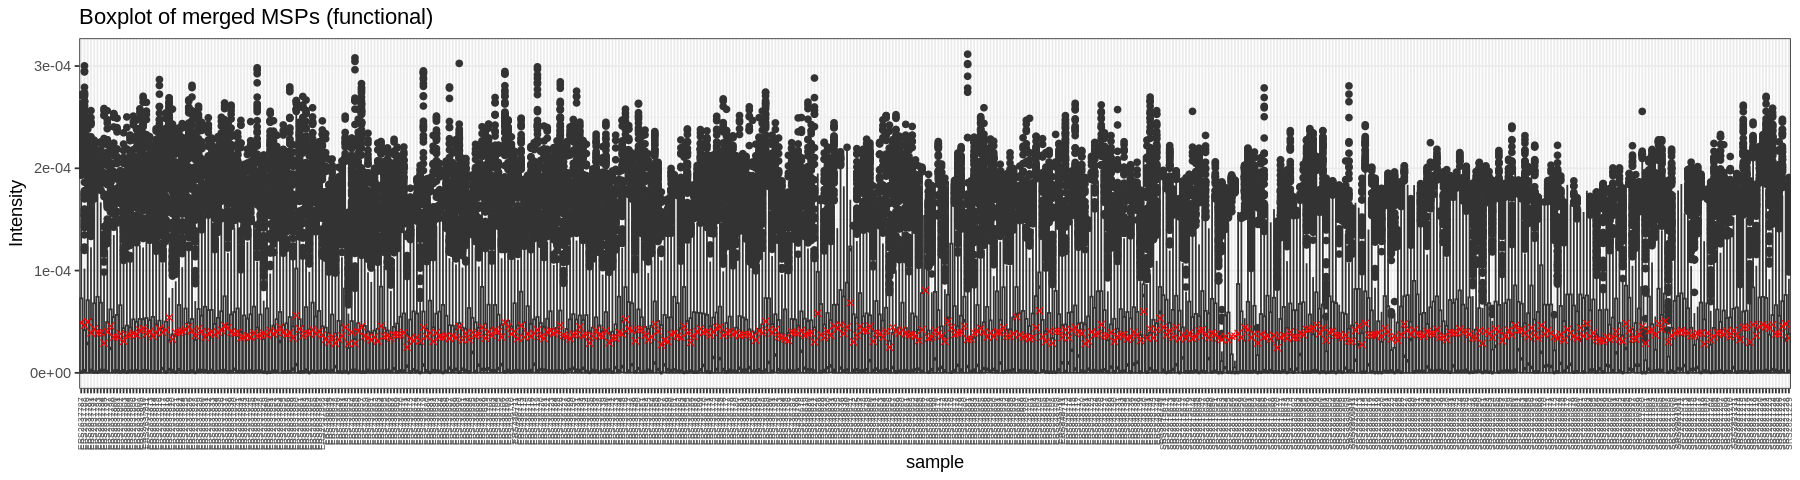

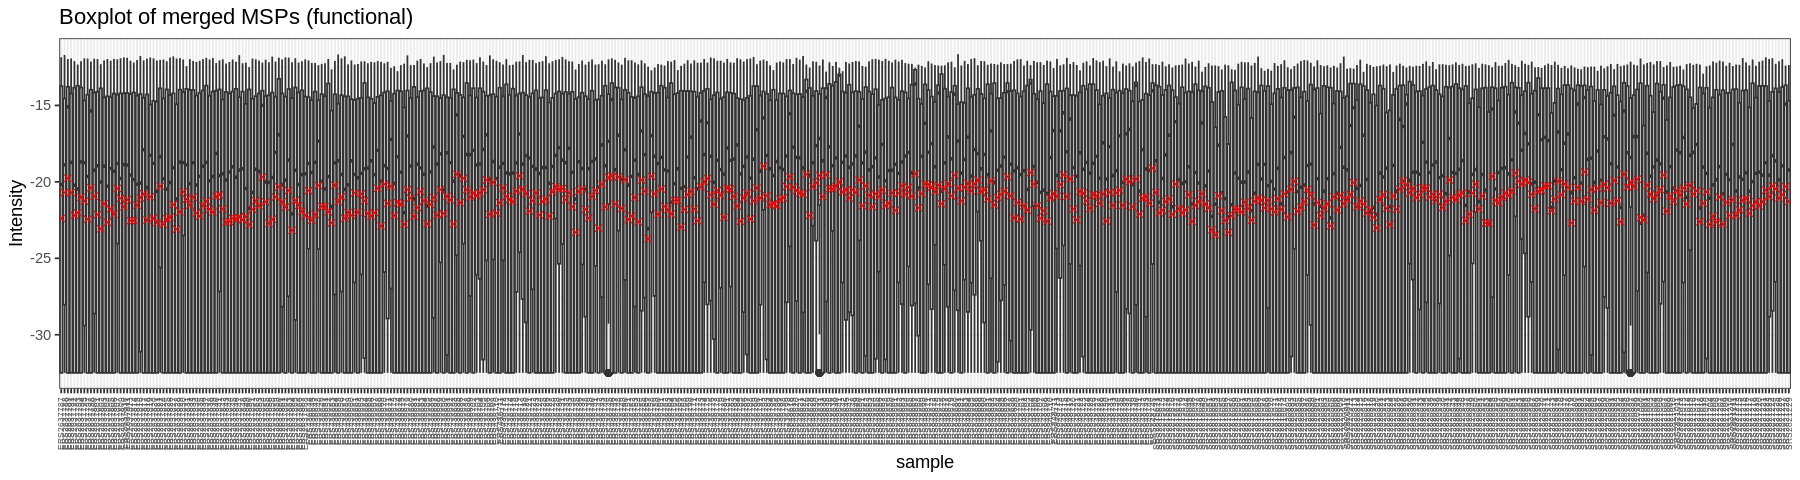

In [107]:
options(repr.plot.width = 15, repr.plot.height = 4)
boxplot_pg(merged_msp, title = "Boxplot of merged MSPs (functional)")
boxplot_pg(log2(merged_msp + min(merged_msp[merged_msp > 0])/2), title = "Boxplot of merged MSPs (functional)")


In [136]:

# log2_merged_msp <- log10(merged_msp + min(merged_msp[merged_msp > 0])/2)

log2_merged_msp <- log2(merged_msp + 1)

## PCA plots

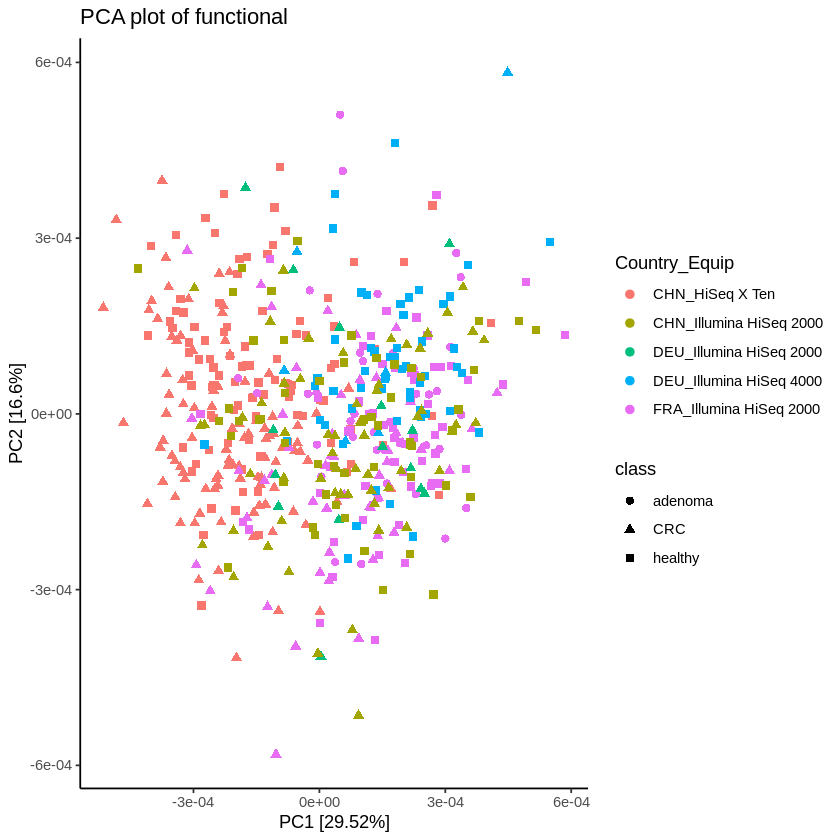

In [137]:
options(repr.plot.width = 7, repr.plot.height = 7)
pca_plot(merged_msp, metadata, 
        title = "PCA plot of functional", 
        color_column = "Country_Equip", shape_column = "class")

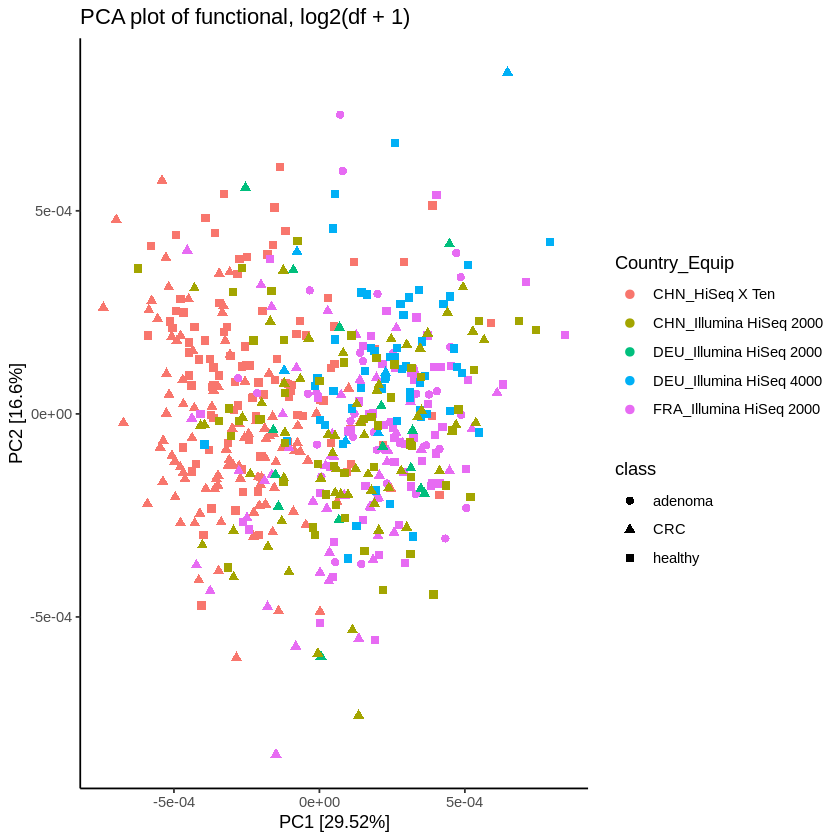

In [139]:
options(repr.plot.width = 7, repr.plot.height = 7)
pca_plot(log2_merged_msp, metadata, 
        title = "PCA plot of functional, log2(df + 1)", 
        color_column = "Country_Equip", shape_column = "class")

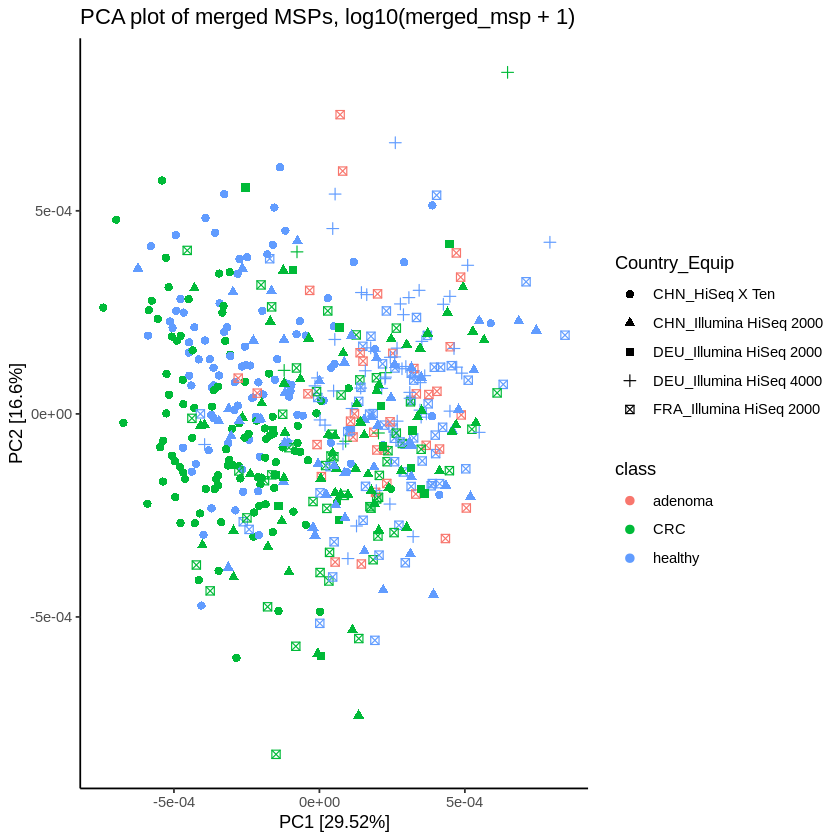

In [140]:
options(repr.plot.width = 7, repr.plot.height = 7)
pca_plot(log2_merged_msp, metadata, 
        title = "PCA plot of merged MSPs, log10(merged_msp + 1)", 
        shape_column = "Country_Equip",  color_column= "class")

In [111]:
library(ggsci)

In [141]:
umap_result = umap(t(log2_merged_msp))

umap_plot = data.frame(umap_result$layout)
umap_plot <- umap_plot %>% 
    rownames_to_column() %>%
    rename(sample = rowname) %>%
    left_join(metadata[,c('sample', 'country', 'class', 'study_accession', 'instrument_model', 'Country_Equip')] ,  by = "sample") %>%
    column_to_rownames("sample")


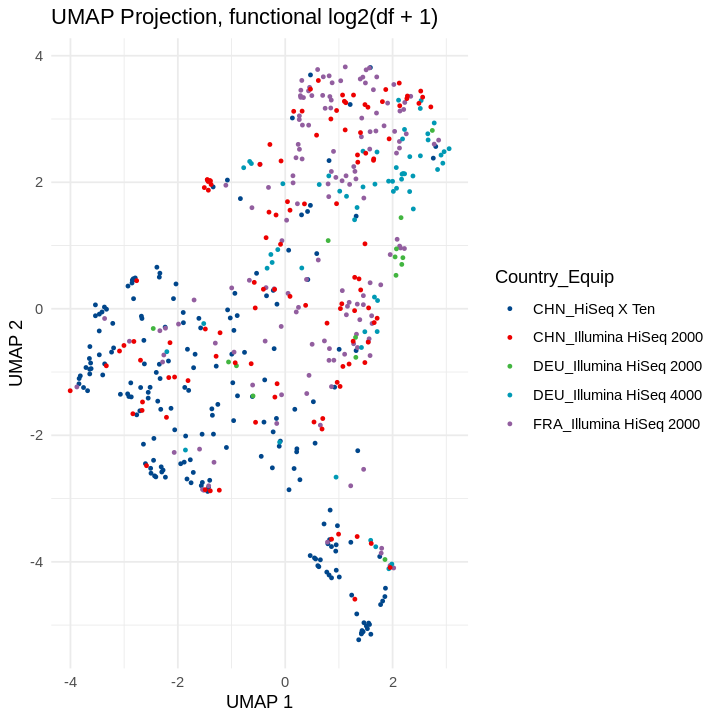

In [143]:

options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(umap_plot, aes(X1, X2)) + 
    geom_point(aes(col=Country_Equip), size = 0.7) +
    scale_color_lancet() + 
    theme_minimal() +
    labs(title = "UMAP Projection, functional log2(df + 1)", x = "UMAP 1", y = "UMAP 2")


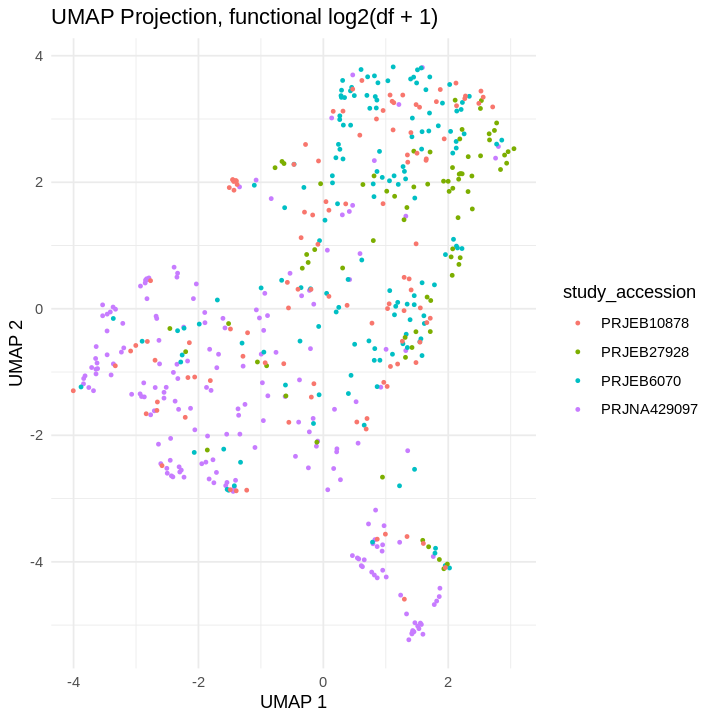

In [144]:
options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(umap_plot, aes(X1, X2)) + 
    geom_point(aes(col=study_accession), size = 0.7) +
    theme_minimal() +
    labs(title = "UMAP Projection, functional log2(df + 1)", x = "UMAP 1", y = "UMAP 2")

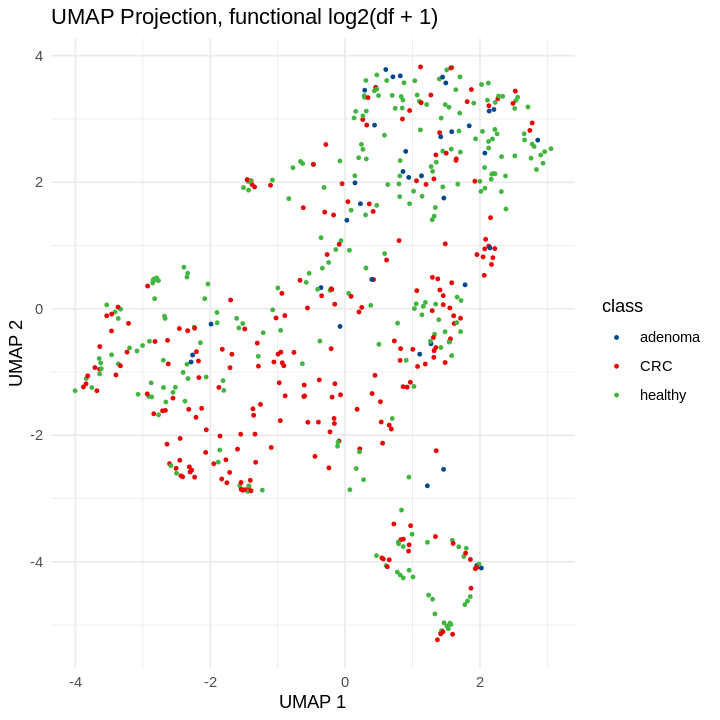

In [145]:
options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(umap_plot, aes(X1, X2)) + 
    geom_point(aes(col=class), size = 0.7) +
    scale_color_lancet() + 
    theme_minimal() +
    labs(title = "UMAP Projection, functional log2(df + 1)", x = "UMAP 1", y = "UMAP 2")

# Correction?

In [116]:
library(limma)

In [117]:
metadata <- metadata %>%
    mutate(study_accession = as.factor(study_accession),
           class = as.factor(class),
           Country_Equip = as.factor(Country_Equip))

## only batch

In [146]:
merged_log2_msp_corrected <- removeBatchEffect(log2_merged_msp, metadata[['Country_Equip']]) %>% as.data.frame()

In [147]:
umap_result = umap(t(merged_log2_msp_corrected))

umap_plot = data.frame(umap_result$layout)
umap_plot <- umap_plot %>% 
    rownames_to_column() %>%
    rename(sample = rowname) %>%
    left_join(metadata[,c('sample', 'country', 'class', 'study_accession', 'instrument_model', 'Country_Equip')] ,  by = "sample") %>%
    column_to_rownames("sample")


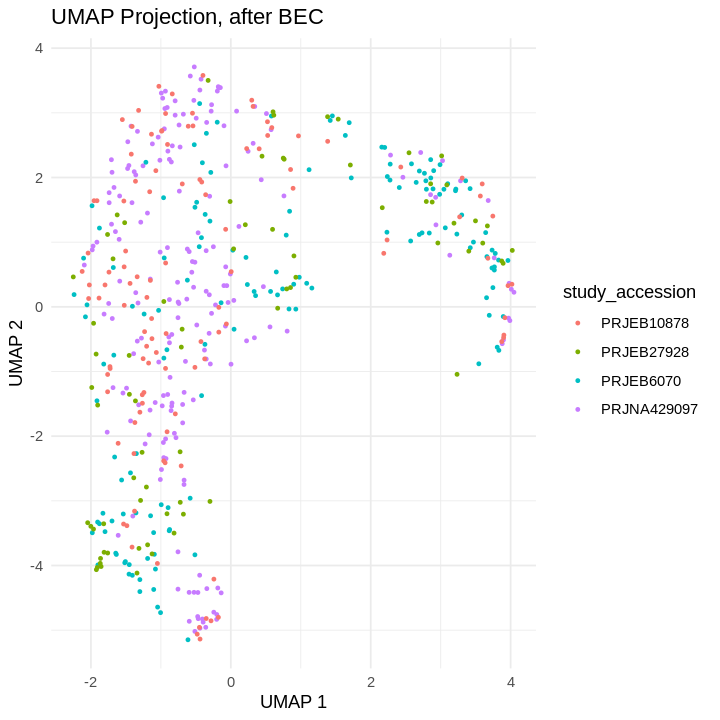

In [120]:
options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(umap_plot, aes(X1, X2)) + 
    geom_point(aes(col=study_accession), size = 0.7) +
    theme_minimal() +
    labs(title = "UMAP Projection, after BEC", x = "UMAP 1", y = "UMAP 2")

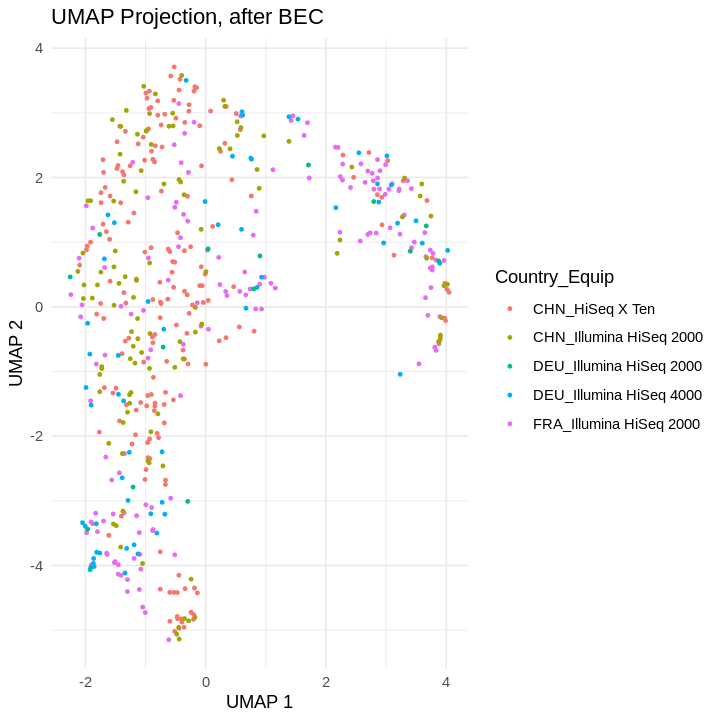

In [121]:
options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(umap_plot, aes(X1, X2)) + 
    geom_point(aes(col=Country_Equip), size = 0.7) +
    theme_minimal() +
    labs(title = "UMAP Projection, after BEC", x = "UMAP 1", y = "UMAP 2")

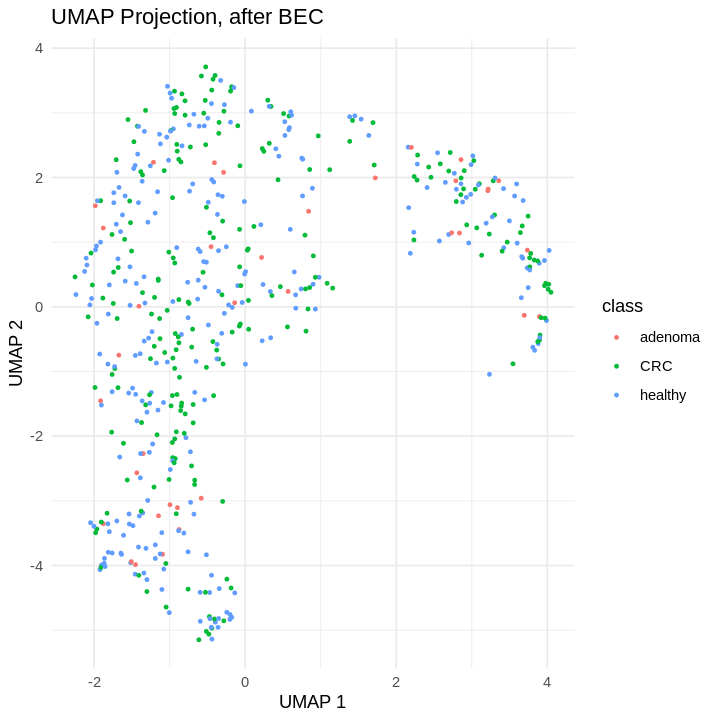

In [122]:
options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(umap_plot, aes(X1, X2)) + 
    geom_point(aes(col=class), size = 0.7) +
    theme_minimal() +
    labs(title = "UMAP Projection, after BEC", x = "UMAP 1", y = "UMAP 2")

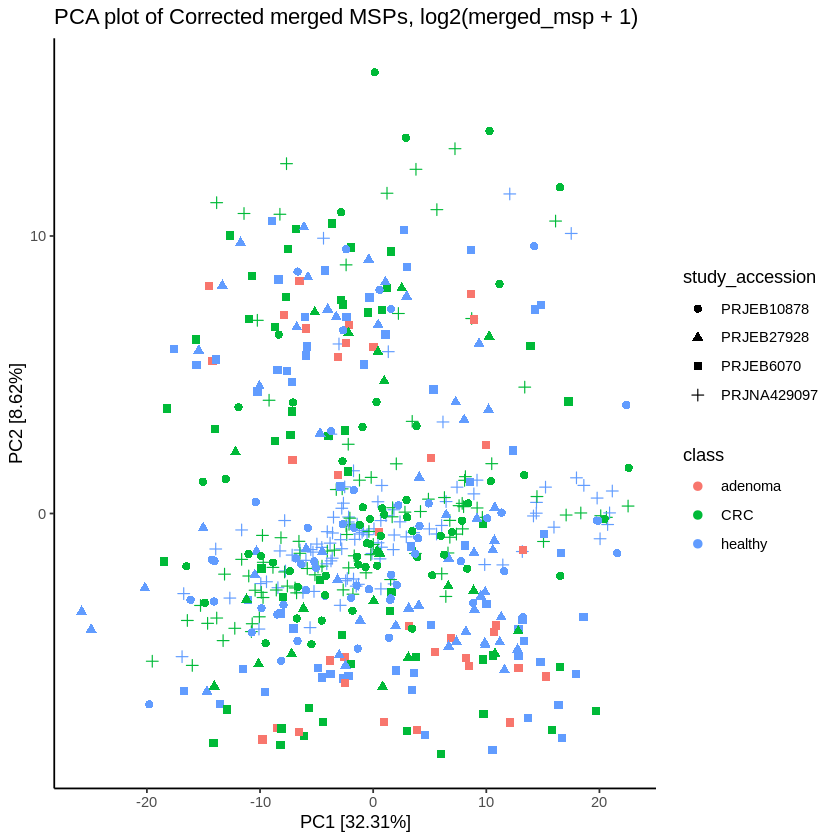

In [123]:
options(repr.plot.width = 7, repr.plot.height = 7)
pca_plot(merged_log2_msp_corrected, metadata, 
        title = "PCA plot of Corrected merged MSPs, log2(merged_msp + 1)", 
        shape_column = "study_accession",  color_column= "class")

## batch + class

In [148]:

design= model.matrix(~class, data = metadata)
merged_msp_corrected <- removeBatchEffect(log2_merged_msp, metadata$Country_Equip, design = design) %>% as.data.frame()


In [149]:
umap_result = umap(t(merged_msp_corrected))

umap_plot = data.frame(umap_result$layout)
umap_plot <- umap_plot %>% 
    rownames_to_column() %>%
    rename(sample = rowname) %>%
    left_join(metadata[,c('sample', 'country', 'class', 'study_accession', 'instrument_model', 'Country_Equip')] ,  by = "sample") %>%
    column_to_rownames("sample")


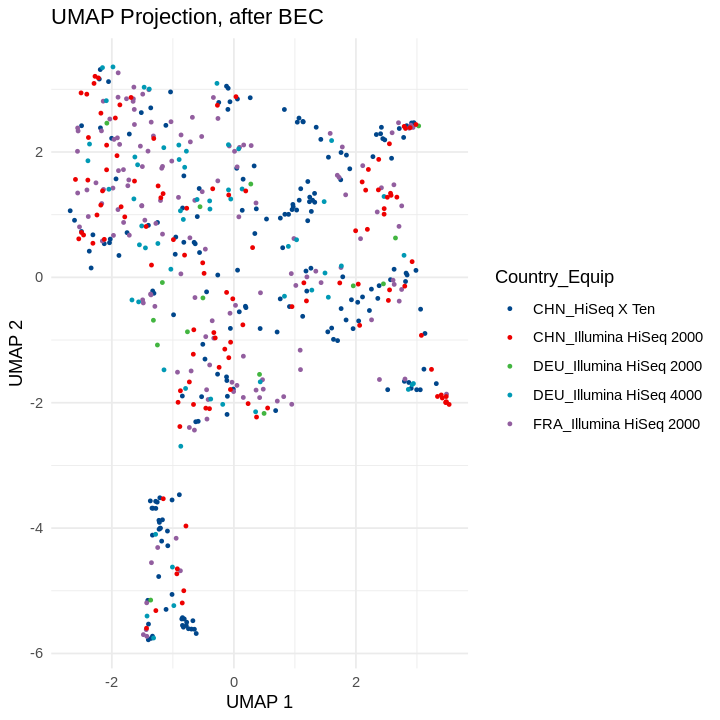

In [151]:
options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(umap_plot, aes(X1, X2)) + 
    geom_point(aes(col=Country_Equip), size = 0.7) +
    scale_color_lancet() + 
    theme_minimal() +
    labs(title = "UMAP Projection, after BEC", x = "UMAP 1", y = "UMAP 2")

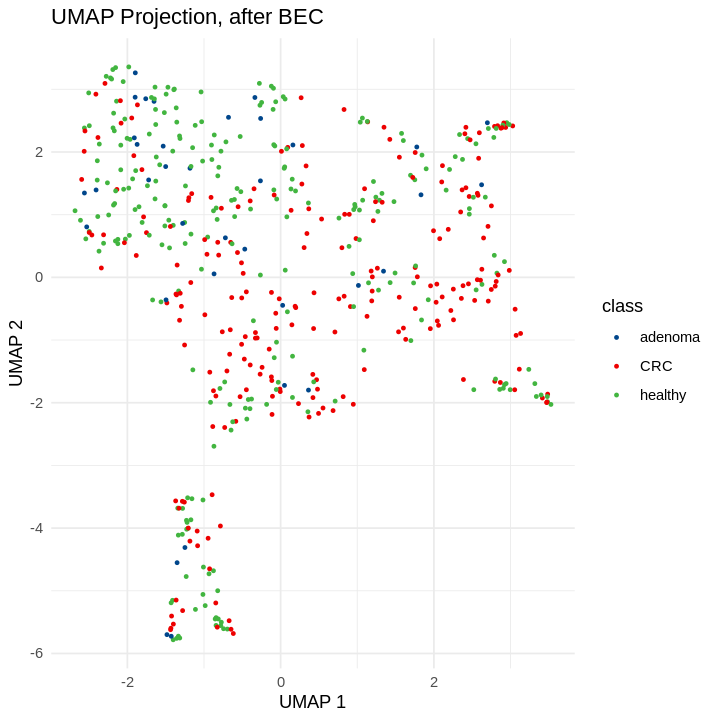

In [152]:
options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(umap_plot, aes(X1, X2)) + 
    geom_point(aes(col=class), size = 0.7) +
    scale_color_lancet() + 
    theme_minimal() +
    labs(title = "UMAP Projection, after BEC", x = "UMAP 1", y = "UMAP 2")

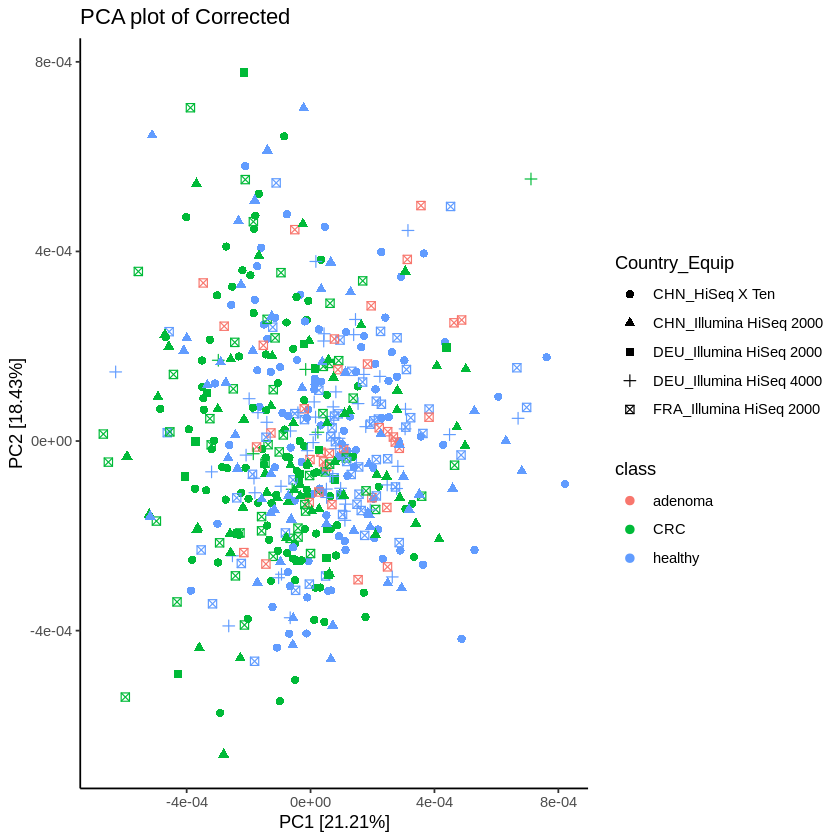

In [155]:
options(repr.plot.width = 7, repr.plot.height = 7)
pca_plot(merged_msp_corrected, metadata, 
        title = "PCA plot of Corrected", 
        shape_column = "Country_Equip",  color_column= "class")

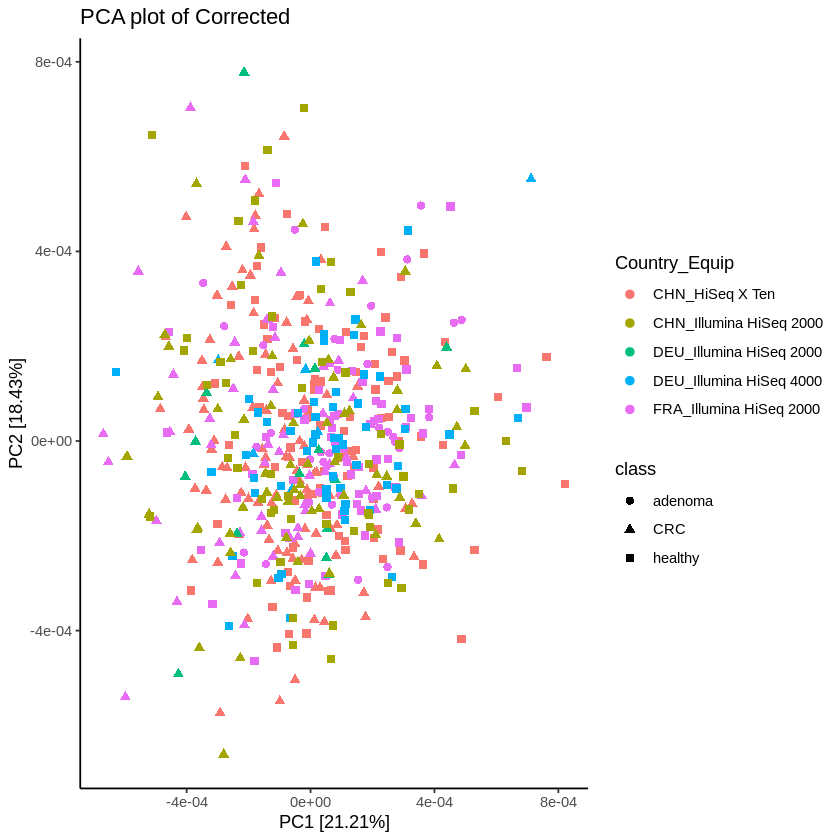

In [156]:
options(repr.plot.width = 7, repr.plot.height = 7)
pca_plot(merged_msp_corrected, metadata, 
        title = "PCA plot of Corrected", 
        color_column = "Country_Equip", shape_column = "class")